<a href="https://colab.research.google.com/github/bachaudhry/paper_implementations/blob/main/generative_modeling/diffusion/vision/implementing_diffedit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementing DiffEdit**

This notebook implements the paper **[DiffEdit](https://arxiv.org/abs/2210.11427)** using the excellent work done by [John Robinson](https://colab.research.google.com/github/johnrobinsn/diffusion_experiments/blob/main/DiffEdit.ipynb).

I will re-implement John's notebook as an exercise to increase my understanding of paper implementation since it is obvious that he is miles ahead in his knowledge and understanding.

It is my hope that I  will be able to churn out similar works of quality in the near future.


## Paper Summary

The key idea behind this paper is:

> Semantic image editing is an extension of image generation, with the additional constraint that the generated image should be as similar as possible to a given input image. Current editing methods based on diffusion models usually require to provide a mask, making the task much easier by treating it as a conditional inpainting task. In contrast, our main contribution is able to automatically generate a mask highlighting regions of the input image that need to be edited, by contrasting predictions of a diffusion model conditioned on different text prompts. Moreover, we rely on latent inference to preserve content in those regions of interest and show excellent synergies with mask-based diffusion. DIFFEDIT achieves state-of-the-art editing performance on ImageNet.

> In our DIFFEDIT approach, a mask generation module determines which part of the image should be edited, and an encoder infers the latents, to provide inputs to a text-conditional diffusion model which produces the image edit.

> ## The Key Steps of DIFFEDIT.

> Step 1: we add noise to the input image, and denoise it: once conditioned on the query text, and once conditioned on a reference text (or unconditionally). We derive a mask based on the difference in the denoising results.

> Step 2: we encode the input image with DDIM, to estimate the latents corresponding to the input image.

> Step 3: we perform DDIM decoding conditioned on the text query, using the inferred mask to replace the background with pixel values coming from the encoding process at the corresponding timestep.


## Setup Notebook

In [1]:
# Install  requirements for colab - dropping version requirements
! pip install -q --upgrade transformers diffusers ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 58.7 MB/s eta 0:00:00


In [2]:
# Import libraries
import numpy as np
import torch
from torch import autocast
from torchvision import transforms as tfms
from transformers import CLIPTextModel, CLIPTokenizer, logging
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel, StableDiffusionInpaintPipeline
from fastdownload import FastDownload
from fastcore.all import concat
from fastai.basics import show_image, show_images
# Secondary
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
import cv2, os
from tqdm.auto import tqdm
from base64 import b64encode # Output animation
from huggingface_hub import notebook_login

from google.colab import userdata
userdata.get('HF_TOKEN')

torch.manual_seed(1)
logging.set_verbosity_error()

# Set Device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
# Summarize tensor
_s = lambda x: (x.shape, x.max(), x.min())

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


## Load Model Pipelines

In [3]:
# Autoencoder model for decoding latents into the image space
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Tokenizer and the text encoder to tokenize and encode the text
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet Model for generating latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012,
                                 beta_schedule="scaled_linear", num_train_timesteps=1000)

# Load the components onto device
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)
vae_magic = 0.18215 # VAE trained with a scaling term to get closer to unit variance

# RunwayML's Inpainting Model
### How does fp32 perform? ###
## Revision will be deprecated
inpaint = StableDiffusionInpaintPipeline.from_pretrained('runwayml/stable-diffusion-inpainting',
                                                         revision="fp16", torch_dtype=torch.float16).to(torch_device)


vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:219: FutureWarning: You are loading the variant fp16 from runwayml/stable-diffusion-inpainting via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
safety_checker/model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/635 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.75k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/608M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/821 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/810 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


## Functions to Convert Latents to Images and Vice Versa

In [4]:
def image2latent(img):
  img = tfms.ToTensor()(img).unsqueeze(0)
  with torch.no_grad():
    latent = vae.encode(img.to(torch_device)*2-1);
  latent = latent.latent_dist.sample() * vae_magic
  return latent

def latents2image(latents):
  latents = latents / vae_magic
  with torch.no_grad():
    imgs = vae.decode(latents).sample
  imgs = (imgs / 2 + 0.5).clamp(0, 1)
  imgs = imgs.detach().cpu().permute(0, 2, 3, 1).numpy()
  imgs = (imgs * 255).round().astype("uint8")
  imgs = [Image.fromarray(i) for i in imgs]
  return imgs

def get_embedding_for_prompt(prompt):
  max_length = tokenizer.model_max_length
  tokens = tokenizer([prompt], padding="max_length", max_length=max_length,
                     truncation=True, return_tensors="pt")
  with torch.no_grad():
    embeddings = text_encoder(tokens.input_ids.to(torch_device))[0]
  return embeddings

## DiffEdit Implementation

In [22]:
# Predict the noise from a starting image latent and a prompt
# which should then be removed to transform a noised sourced image
# to a denoised image guided by the prompt.
def predict_noise(text_embeddings, img_latents, seed=torch.seed(), guidance_scale=7,
                  strength=0.5, **kwargs):
  # Denoising steps
  num_inference_steps = 50
  # Seed generator to create the initial latent noise
  uncond = get_embedding_for_prompt('')
  text_embeddings = torch.cat([uncond, text_embeddings])

  # Prep scheduler
  scheduler.set_timesteps(num_inference_steps)

  offset = scheduler.config.get("steps_offset", 0)
  init_timestep = int(num_inference_steps * strength) + offset
  init_timestep = min(init_timestep, num_inference_steps)

  timesteps = scheduler.timesteps[-init_timestep]
  timesteps = torch.tensor([timesteps] * 1 * 1, device=torch_device)

  start_step = init_timestep
  noise = torch.randn_like(img_latents) # Nice!
  latents = scheduler.add_noise(img_latents, noise, timesteps=timesteps)
  latents = latents.to(torch_device).float()

  t_start =max(num_inference_steps - init_timestep + offset, 0)
  timesteps = scheduler.timesteps[t_start:].to(torch_device)

  noisy_latent = latents.clone()

  noise_pred = None
  for i, tm in enumerate(timesteps):
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, tm)
    # Predict noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, tm, encoder_hidden_states=text_embeddings)["sample"]

    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)

    u = noise_pred_uncond
    g = guidance_scale
    t = noise_pred_text
    # Perform guidance
    noise_pred = u + g * (t - u)
    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, tm, latents).prev_sample

  return latents2image(latents)[0], noise_pred


In [6]:
# For a reference prompt and a query prompt, run the diffusion process 10 times
# and calculate the noise distance for each sample
def calc_diffedit_samples(encoded, prompt1, prompt2, n=10, **kwargs):
  diffs = []
  # Generating a list of n seeds to reproduce the mask generation
  torch.manual_seed(torch.seed() if 'seed' not in kwargs else kwargs['seed'])
  seeds = torch.randint(0, 2**62, (10,)).tolist() ## ?
  for i in range(n):
    # Use the same seed for the two noise samples
    kwargs['seed'] = seeds[i]
    emb1 = get_embedding_for_prompt(prompt1)
    _img1, n1 = predict_noise(emb1, encoded, **kwargs)
    emb2 = get_embedding_for_prompt(prompt2)
    _img2, n2 = predict_noise(emb2, encoded, **kwargs)

    # Aggregate the channel components by taking Euclidean distance
    diffs.append((n1 - n2)[0].pow(2).sum(dim=0).pow(0.5)[None])
  all_masks = torch.cat(diffs)
  return all_masks

# For an image latent and 2 prompts, generate grayscale diff by sampling the noise predictions
# between prompts
def calc_diffedit_diff(img_latent, prompt1, prompt2, **kwargs):
  m = calc_diffedit_samples(img_latent, prompt1, prompt2, **kwargs)
  # Averaging the two samples
  m = m.mean(axis=0)
  # Rescale to interval [0, 1]
  m = (m - m.min()) / (m.max() - m.min())
  m = (m * 255.).cpu().numpy().astype(np.uint8)
  m = Image.fromarray(m)
  return m

# Try to improve the mask through convolutions etc.
# Assume m is a PIL object containing a grayscale diff
def process_diffedit_mask(m, threshold=0.35, **kwargs):
  m = np.array(m).astype(np.float32)
  m = cv2.GaussianBlur(m, (5, 5), 1)
  m = (m > (255.*threshold)).astype(np.float32)*255
  m = Image.fromarray(m.astype(np.uint8))
  return m

# Given an image latent and 2 prompts, generate a binarized mask (PIL) appropriate for Inpainting
def calc_diffedit_mask(img_latent, prompt1, prompt2, **kwargs):
  m = calc_diffedit_diff(img_latent, prompt1, prompt2, **kwargs)
  m = process_diffedit_mask(m, **kwargs)
  m = m.resize((512, 512))
  return m

In [7]:
# Composite the mask over the provided image for demos
def get_blended_mask(img, mask_gray):
  mask_rgb = mask_gray.convert('RGB')
  return Image.blend(img, mask_rgb, 0.40)

# How original image, the original + mask and the inpainted image
def demo_diffedit(img_path, prompt1, prompt2, **kwargs):
  img_path = Path(img_path)
  out = []

  img = Image.open(img_path).resize((512, 512))
  img_latent = image2latent(img)
  out.append(img)

  if 'seed' not in kwargs: kwargs['seed'] = torch.seed()
  mask = calc_diffedit_mask(img_latent, prompt1, prompt2, **kwargs)
  out.append(get_blended_mask(img, mask))
  out.append(inpaint(prompt=[prompt2], image=img, mask_image=mask,
                     generator=torch.Generator(torch_device).manual_seed(kwargs['seed'])).images[0])
  show_images(out)

### Download Target Image(s) and Demo Mask Generation

Based on what I understood from the DiffEdit paper, the authors ran a number of experiments on a variety of compositions for their target images which included animals in natural settings - while also including inanimate objects, machinery, buildings etc. The latter compositions seem to be more challenging since their are more elements in the pictures which need to be differentiated while masking.

Secondly, looking at the different implementations that I've come across the web, it seems that everyone was (mostly) focused on animals in natural settings for their target images. So I'm definitely inclined towards applying the paper's masking strategy to complex compositions featuring inanimate objects.

I'll randomly select some pics from a DDG search.

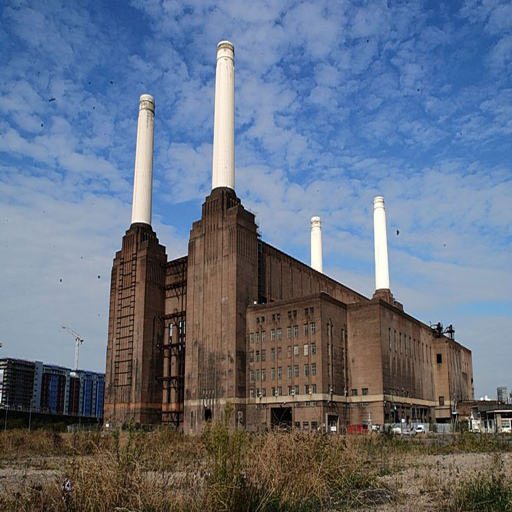

In [8]:
img = FastDownload().download('https://www.designingbuildings.co.uk/w/images/0/05/Battersea.jpg')
img = Image.open(img).convert("RGB").resize((512, 512))
img

In [9]:
# Moving our reference to the latent space
latent = image2latent(img)
latent.shape

torch.Size([1, 4, 64, 64])

seed: 1833713792923


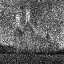

In [23]:
# This is the primary bottleneck since the mask generation algorithm requires that
# we run the stable diffusion process ~20 times for a given pair of prompts
seed = 1833713792923
print('seed:', seed)
mask = calc_diffedit_diff(latent, 'Old Factory Building', 'Modern Glass Building', seed=seed)
# Resample from 64x64 pixel mask to size of original image
mask

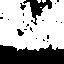

In [24]:
# Taking the grayscale diff mask and post process to get the binarized mask
binarized_mask = process_diffedit_mask(mask)
binarized_mask

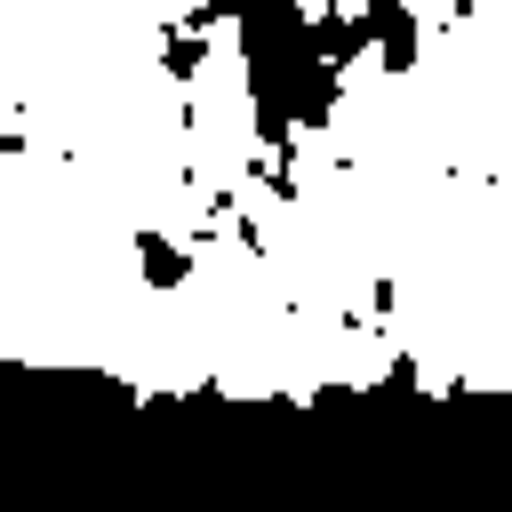

In [25]:
# The mask must be scaled back from 64x64 to 512x512 for use with inpainting
binarized_mask = binarized_mask.resize((512, 512))
binarized_mask

seed:  81254622733


  0%|          | 0/50 [00:00<?, ?it/s]

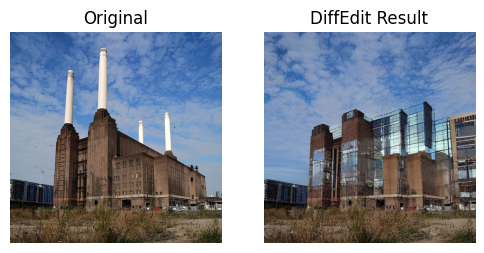

In [26]:
# Using the mask to do stable diffusion in painting using the target prompt

seed = 81254622733
print('seed: ', seed)
generator = torch.Generator(torch_device).manual_seed(seed)
img_result = inpaint(prompt=["Modern Glass Building"], image=img, mask_image=binarized_mask,
                     generator=generator).images[0]
show_images([img, img_result], titles=['Original', 'DiffEdit Result'])

## Extended Demo

interactive(children=(FloatSlider(value=0.35, description='threshold', max=1.0, step=0.05), Output()), _dom_cl…

<function __main__.f(threshold)>

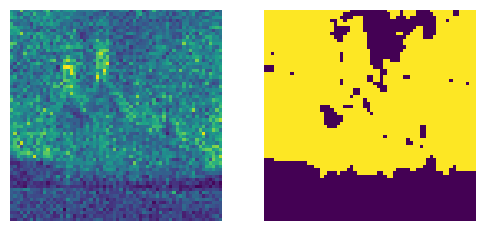

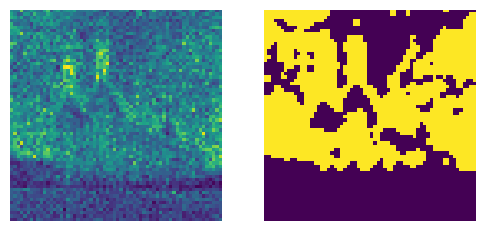

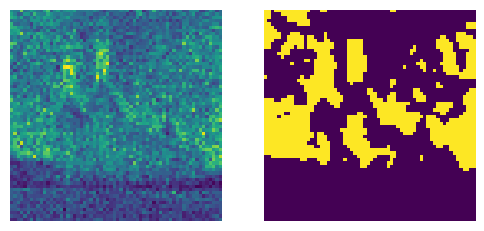

In [33]:
from ipywidgets import interact,FloatSlider

def f(threshold):
    show_images([mask,process_diffedit_mask(mask,threshold)])
    return

interact(f,threshold=FloatSlider(min=0.,max=1.,value=0.35,step=0.05))

seed:  8763426347


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

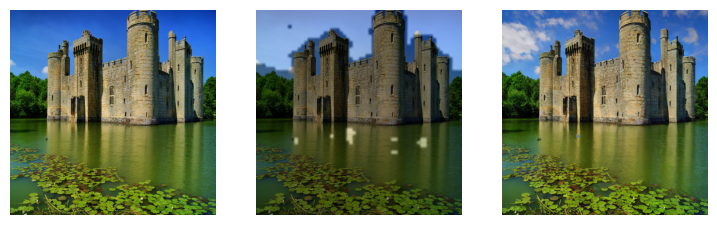

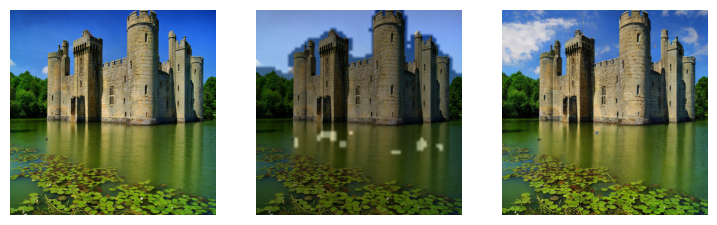

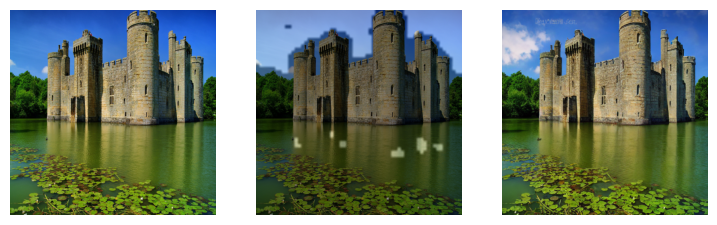

In [34]:
prompts = [
    ('Ancient European Fortress', 'Modern Glass Building'),
    ('Ancient European Fortress', '19th Century Palace'),
    ('Ancient European Fortress', 'Ancient Japanese Castle'),
]

seed = 8763426347
print('seed: ', seed)
img_path = FastDownload().download('https://wallpapercave.com/wp/wp4738130.jpg')
for p in prompts:
  demo_diffedit(img_path, *p, seed=seed)


seed:  32343424243


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

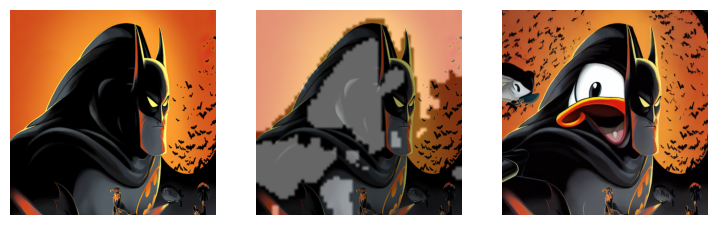

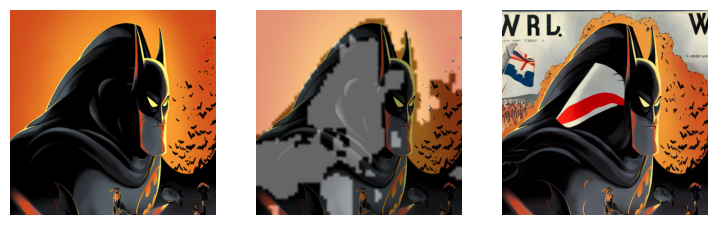

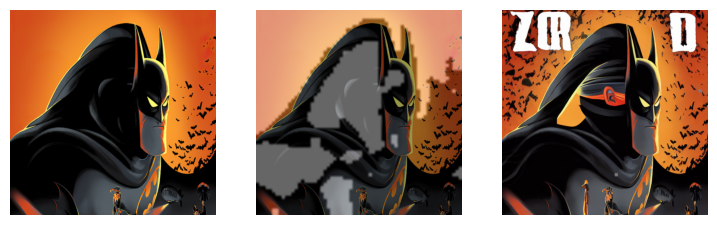

In [35]:
prompts = [
    ('Iconic Batman Poster', 'Donald Duck Cartoon'),
    ('Iconic Batman Poster', 'World War 2 Propaganda'),
    ('Iconic Batman Poster', 'Zorro Poster'),
]

seed = 32343424243
print('seed: ', seed)
img_path = FastDownload().download('https://images.hdqwalls.com/download/batman-animate-l2-2560x1440.jpg')
for p in prompts:
  demo_diffedit(img_path, *p, seed=seed, threshold=0.35)

seed:  32343424243


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

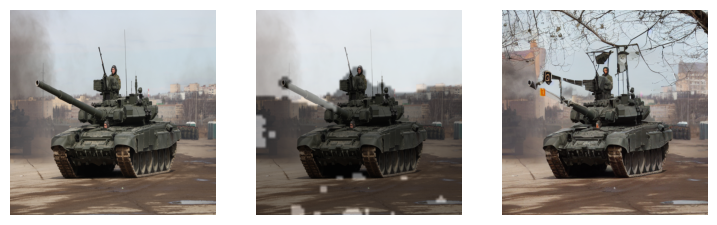

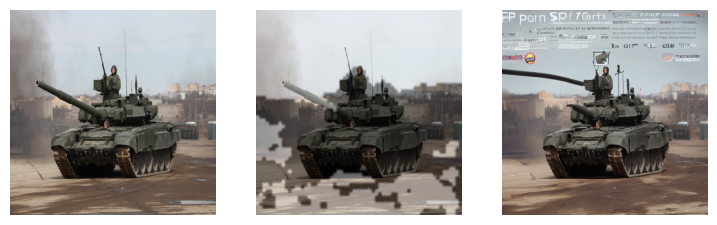

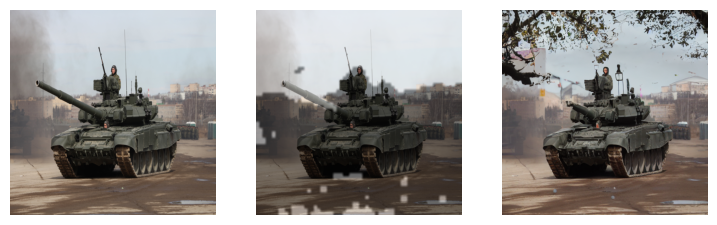

In [36]:
prompts = [
    ('Battle Tank', 'Dump Truck'),
    ('Battle Tank', 'Sports Car'),
    ('Battle Tank', 'Food Van'),
]

seed = 32343424243
print('seed: ', seed)
img_path = FastDownload().download('https://wallup.net/wp-content/uploads/2019/09/331812-t-90a-main-battle-tank-russian-army-russia-parade-victory-day-parade-2014-rehearsal-in-alabin-1.jpg')
for p in prompts:
  demo_diffedit(img_path, *p, seed=seed)